In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from tensorflow.keras.layers import concatenate

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
tf.random.set_seed(123)

#set_random_seed(123)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
#tf.keras.backend.set_session(sess)
tf.random.set_seed(2)
np.random.seed(1)

Dataset :https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving

In [2]:
print(os.listdir(r"C:\Users\P Srivalli Patel\Downloads\dataset\dataset_updated"))

['.DS_Store', 'colorisation.ipynb', 'modelcolourization.h5', 'training_set', 'using_pretrainedmodel.ipynb', 'validation_set']


In [3]:
ImagePath=r"C:/Users/P Srivalli Patel/Downloads/dataset/dataset_updated/training_set/sculpture/"

In [4]:
if os.path.exists(ImagePath+"4.jpg"):
    img = cv2.imread(ImagePath + "4.jpg" )
else:
    print("Path does not exist:", ImagePath)

(224, 224, 3)

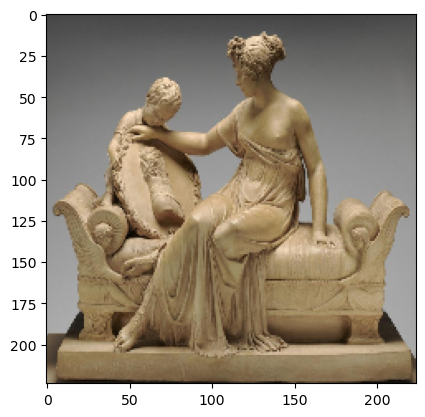

In [5]:
img = cv2.imread(ImagePath+"4.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape


In [6]:
HEIGHT=224
WIDTH=224

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [7]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [8]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
   
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [9]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [10]:
LEARNING_RATE = 0.0015
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error',metrics=['accuracy'])
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         160       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         4640      ['leaky_re_lu[0][0]']         
                                                                                              

In [11]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
history=Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=38,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))

C:\Users\P Srivalli Patel\AppData\Local\Temp\ipykernel_19792\1311520009.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=38,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))


Epoch 1/53
38/38 [==============================] - 27s 603ms/step - loss: 0.0636 - accuracy: 0.6564
Epoch 2/53
38/38 [==============================] - 23s 619ms/step - loss: 0.0100 - accuracy: 0.4488
Epoch 3/53
38/38 [==============================] - 23s 617ms/step - loss: 0.0028 - accuracy: 0.5288
Epoch 4/53
38/38 [==============================] - 23s 608ms/step - loss: 0.0026 - accuracy: 0.4318
Epoch 5/53
38/38 [==============================] - 23s 609ms/step - loss: 0.0175 - accuracy: 0.5106
Epoch 6/53
38/38 [==============================] - 24s 635ms/step - loss: 0.0137 - accuracy: 0.5977
Epoch 7/53
38/38 [==============================] - 24s 641ms/step - loss: 0.0040 - accuracy: 0.4193
Epoch 8/53
38/38 [==============================] - 38s 1s/step - loss: 0.0031 - accuracy: 0.5050
Epoch 9/53
38/38 [==============================] - 27s 702ms/step - loss: 0.0012 - accuracy: 0.4763
Epoch 10/53
38/38 [==============================] - 32s 843ms/step - loss: 4.1631e-04 - accur

38/38 [==============================] - 19s 504ms/step - loss: 1.2996e-05 - accuracy: 0.4879


dict_keys(['loss', 'accuracy'])


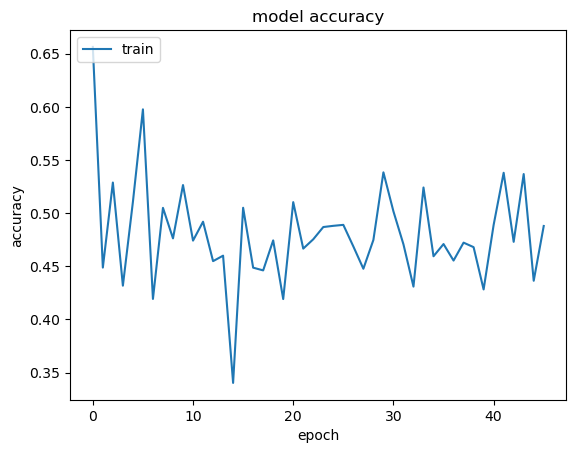

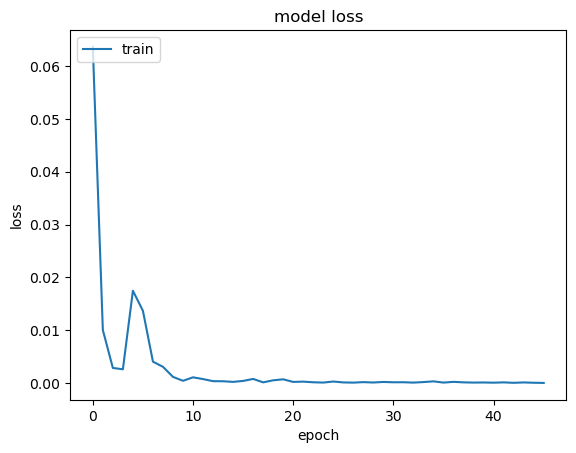

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# serialize weights to HDF5
Model_Colourization.save_weights("modelcolourization.h5")
print("Saved model to disk")
# load weights into new model
Model_Colourization.load_weights("modelcolourization.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [14]:
TestImagePath="C:/Users/P Srivalli Patel/Downloads/dataset/test_dataset/"

In [15]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [16]:
ImagePath=TestImagePath+"2.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

1/1 [==============================] - 0s 351ms/step


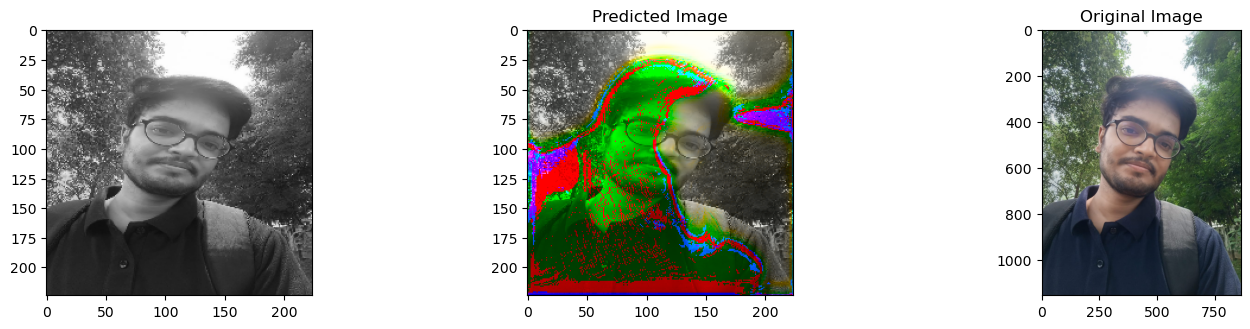

In [17]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"3.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Original Image")
plt.imshow(img_1)